In [1]:
!wget https://www.dropbox.com/s/tc1qo73rrm3gt3m/CARVANA.zip

--2022-11-29 15:16:45--  https://www.dropbox.com/s/tc1qo73rrm3gt3m/CARVANA.zip
Resolving www.dropbox.com (www.dropbox.com)... 162.125.65.18, 2620:100:6026:18::a27d:4612
Connecting to www.dropbox.com (www.dropbox.com)|162.125.65.18|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: /s/raw/tc1qo73rrm3gt3m/CARVANA.zip [following]
--2022-11-29 15:16:45--  https://www.dropbox.com/s/raw/tc1qo73rrm3gt3m/CARVANA.zip
Reusing existing connection to www.dropbox.com:443.
HTTP request sent, awaiting response... 302 Found
Location: https://uc650fe10191db83e8977c57ccca.dl.dropboxusercontent.com/cd/0/inline/BxqVr5HJm1_I3V7rSmSUi4XxEysoFTW3UuNrL27sm4Gp1owLdQ_CEc5KN5FRkxK5p5h14B0YxzHmLQXjP9oSUbzxT_oHkRz5vFgp6T7ktCTV5XjcaT688pOwl-mDrhmxl3czwQ7DIjhG3EtsVp1hboqJ6J5kuSODLByLNhXKo6kqbA/file# [following]
--2022-11-29 15:16:46--  https://uc650fe10191db83e8977c57ccca.dl.dropboxusercontent.com/cd/0/inline/BxqVr5HJm1_I3V7rSmSUi4XxEysoFTW3UuNrL27sm4Gp1owLdQ_CEc5KN5FRkxK5p5h14B0YxzHmLQXj

In [2]:
!unzip -q CARVANA.zip

In [3]:
!rm -rf ./train/.DS_Store
!rm -rf ./train_masks/.DS_Store

In [4]:
!pip install colour

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [5]:
import os
import warnings
from os.path import isfile, join
from typing import Dict, List, Tuple, Union

import cv2
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import torch
import torch.nn.functional as F
import torchvision
import torch.optim as optim
from colour import Color
from PIL import Image
from torch import nn
from torch.utils.data import DataLoader
from torch.utils.data.dataset import Dataset
from torchvision import datasets, models, transforms 
from tqdm.notebook import trange, tqdm

warnings.filterwarnings("ignore")

In [6]:
class Carvana(Dataset):
    def __init__(
        self,
        root: str,
        transform: transforms.Compose = None,
    ) -> None:
        """
        :param root: путь к папке с данными
        :param transform: transforms of the images and labels
        """
        self.root = os.path.expanduser(root)
        self.transform = transform
        (self.data_path, self.labels_path) = ([], [])

        def load_images(path: str) -> List[str]:
            """
            Возвращает список с путями до всех изображений

            :param path: путь к папке с данными
            :return: лист с путями до всех изображений
            """
            images_dir = [join(path, f) for f in os.listdir(path)
                          if isfile(join(path, f))]
            images_dir.sort()

            return images_dir

        self.data_path = load_images(self.root + "/train")
        self.labels_path = load_images(self.root + "/train_masks")

    def __getitem__(self, index: int) -> Tuple[torch.Tensor, torch.Tensor]:
        """
        :param index: sample index
        :return: tuple (img, target) with the input data and its label
        """
        img = Image.open(self.data_path[index])
        target = Image.open(self.labels_path[index])

        if self.transform is not None:
            img = self.transform(img)
            target = self.transform(target)
            target = (target > 0).float()

        return (img, target)

    def __len__(self):
        return len(self.data_path)

    
def im_show(img_list: List[Tuple[str, str]]) -> None:
    """
    Plots images with correspinding segmentation mask
    
    :param img_list: list of paths to images
    """

    to_PIL = transforms.ToPILImage()
    if len(img_list) > 9:
        raise Exception("len(img_list) must be smaller than 10")
        
    fig, axes = plt.subplots(len(img_list), 2, figsize=(16, 16))
    fig.tight_layout()

    for (idx, sample) in enumerate(img_list):
        a = axes[idx][0].imshow(np.array(to_PIL(sample[0])))
        b = axes[idx][1].imshow(np.array(to_PIL(sample[1])))
        for ax in axes[idx]:
            ax.get_xaxis().set_visible(False)
            ax.get_yaxis().set_visible(False)
            
    plt.show()



In [7]:
train_dataset = Carvana(
    root=".",
    transform=transforms.Compose([
        transforms.Resize((256, 256)),
        transforms.ToTensor()
    ])
)

train_loader = torch.utils.data.DataLoader(
    dataset=train_dataset,
    batch_size=128,
    shuffle=True,
    pin_memory=True,
    num_workers=2
)

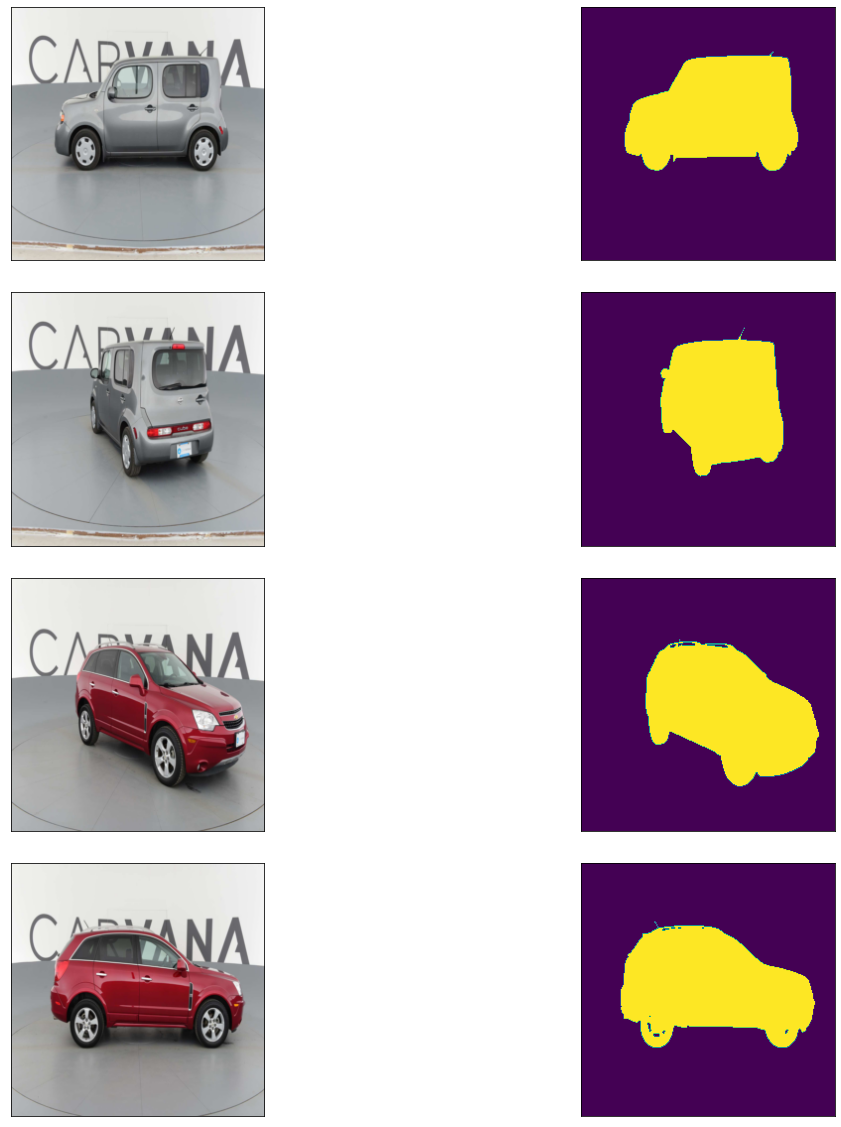

In [8]:
img_list = []
for i in range(4):
    img, label = train_dataset[np.random.randint(0, 100)]
    img_list.append((img, label))

im_show(img_list)

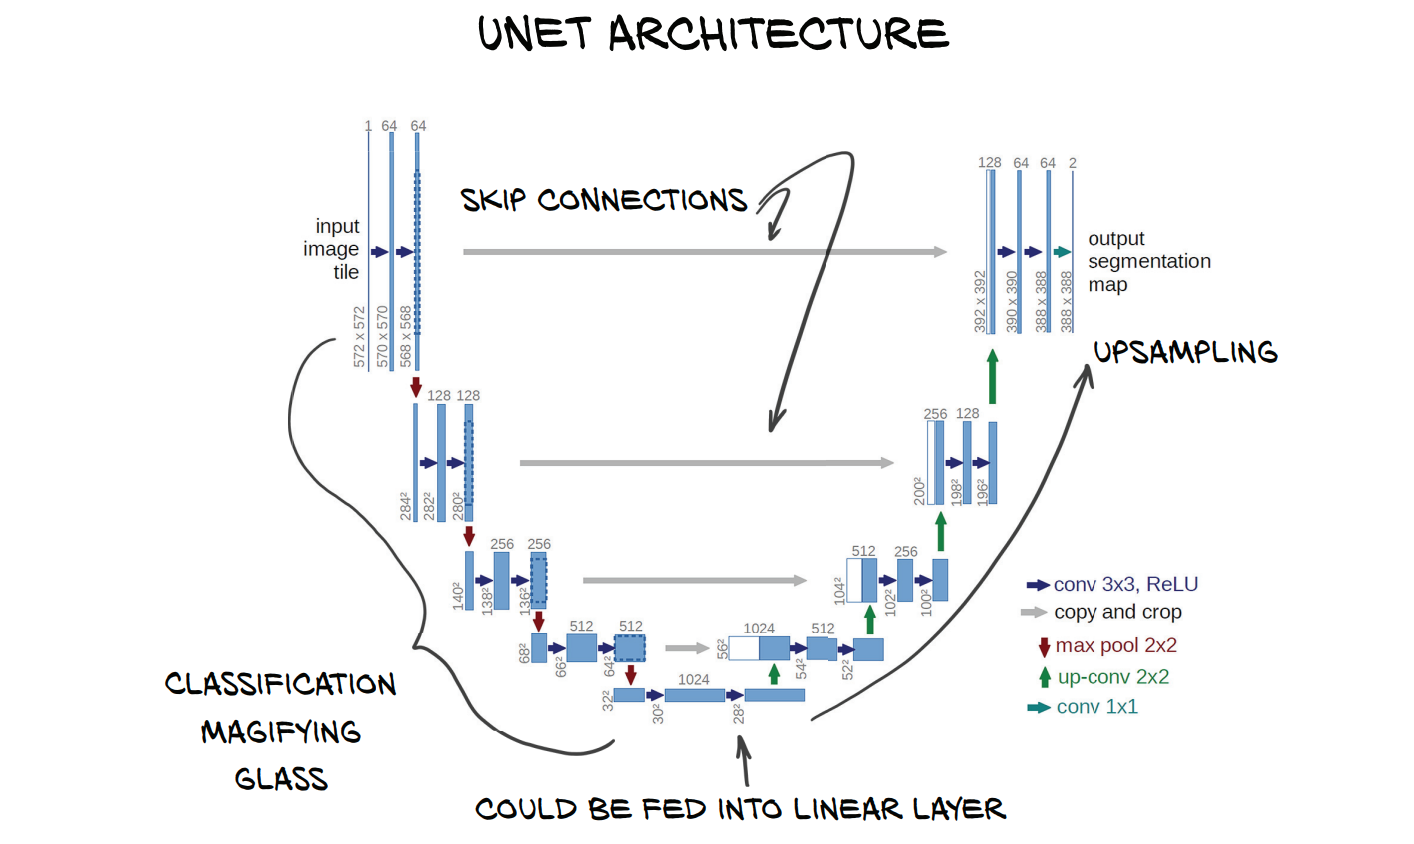

In [56]:
class Block(nn.Module):
    def __init__(self, in_ch, out_ch):
        super().__init__()
        self.conv1 = nn.Conv2d(in_ch, out_ch, 3,padding=1,stride=1)
        self.relu  = nn.ReLU(inplace=True)
        self.conv2 = nn.Conv2d(out_ch, out_ch, 3,padding=1,stride=1)
        self.bn = nn.BatchNorm2d(out_ch)
    
    def forward(self, x):
      x=self.conv1(x)
      x=self.bn(x)
      x=self.relu(x)
      x=self.conv2(x)
      x=self.bn(x)
      x=self.relu(x)
      return x

In [57]:
block=Block(3,16)
block(torch.randn(1,3,256,256)).shape

torch.Size([1, 16, 256, 256])

In [58]:
class Encoder(nn.Module):
    def __init__(self, chs=(3,16,32,64,128)):
        super().__init__()
        self.enc_blocks = nn.ModuleList([Block(chs[i], chs[i+1]) for i in range(len(chs)-1)])
        self.pool       = nn.MaxPool2d(2)
    
    def forward(self, x):
        ftrs = []
        for block in self.enc_blocks:
            x = block(x)
            ftrs.append(x)
            x = self.pool(x)
        return ftrs

In [59]:
encoder = Encoder()
# input image
x    = torch.randn(1, 3, 256, 256)
ftrs = encoder(x)
for ftr in ftrs: print(ftr.shape)

torch.Size([1, 16, 256, 256])
torch.Size([1, 32, 128, 128])
torch.Size([1, 64, 64, 64])
torch.Size([1, 128, 32, 32])


In [60]:
class Decoder(nn.Module):
    def __init__(self, chs=(128, 64, 32, 16)):
        super().__init__()
        self.chs         = chs
        self.upconvs    = nn.ModuleList([nn.ConvTranspose2d(chs[i], chs[i+1], 2, 2) for i in range(len(chs)-1)])
        self.dec_blocks = nn.ModuleList([Block(chs[i], chs[i+1]) for i in range(len(chs)-1)]) 
        
    def forward(self, x, encoder_features):
        for i in range(len(self.chs)-1):
            x        = self.upconvs[i](x)
            enc_ftrs = self.crop(encoder_features[i], x)
            x        = torch.cat([x, enc_ftrs], dim=1)
            x        = self.dec_blocks[i](x)
        return x
    
    def crop(self, enc_ftrs, x):
        _, _, H, W = x.shape
        enc_ftrs   = torchvision.transforms.CenterCrop([H, W])(enc_ftrs)
        return enc_ftrs

In [61]:
class UNet(nn.Module):
    def __init__(self, enc_chs=(3,16,32,64,128), dec_chs=(128, 64, 32, 16), num_class=1, retain_dim=False, out_sz=(256,256)):
        super().__init__()
        self.encoder     = Encoder(enc_chs)
        self.decoder     = Decoder(dec_chs)
        self.head        = nn.Conv2d(dec_chs[-1], num_class, 1)
        self.retain_dim  = retain_dim

    def forward(self, x):
        enc_ftrs = self.encoder(x)
        out      = self.decoder(enc_ftrs[::-1][0], enc_ftrs[::-1][1:])
        out      = self.head(out)
        if self.retain_dim:
            out = F.interpolate(out, out_sz)
        return out

In [62]:
unet = UNet()
x    = torch.randn(1, 3, 256, 256)
unet(x).shape

torch.Size([1, 1, 256, 256])

In [63]:
def train(train_loader, model, criterion, epoch, num_epochs, device):
    model.train()

    pbar = tqdm(enumerate(train_loader), total=len(train_loader))
    for i, (images, labels) in pbar:
        images = images.to(device)
        labels = labels.to(device)

        optimizer.zero_grad()
        outputs = torch.sigmoid(model(images))
        
        loss = criterion(outputs, labels)
        
        accuracy = ((outputs > 0.5) == labels).float().mean()
            
        pbar.set_description(
            f"Loss: {round(loss.item(), 4)} "
            f"Accuracy: {round(accuracy.item() * 100, 4)}"
        )

        loss.backward()
        optimizer.step()

In [64]:
device = "cuda"
model = UNet().to(device)

In [65]:
!pip install torchinfo
from torchinfo import summary
summary(model,input_size=(1,3,256,256))

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


Layer (type:depth-idx)                   Output Shape              Param #
UNet                                     [1, 1, 256, 256]          --
├─Encoder: 1-1                           [1, 16, 256, 256]         --
│    └─ModuleList: 2-7                   --                        (recursive)
│    │    └─Block: 3-1                   [1, 16, 256, 256]         2,800
│    └─MaxPool2d: 2-2                    [1, 16, 128, 128]         --
│    └─ModuleList: 2-7                   --                        (recursive)
│    │    └─Block: 3-2                   [1, 32, 128, 128]         13,952
│    └─MaxPool2d: 2-4                    [1, 32, 64, 64]           --
│    └─ModuleList: 2-7                   --                        (recursive)
│    │    └─Block: 3-3                   [1, 64, 64, 64]           55,552
│    └─MaxPool2d: 2-6                    [1, 64, 32, 32]           --
│    └─ModuleList: 2-7                   --                        (recursive)
│    │    └─Block: 3-4                

In [66]:
criterion = torch.nn.BCELoss() 
optimizer = torch.optim.Adam(model.parameters())

In [67]:
num_epochs = 1
for epoch in range(0, num_epochs):
    train(train_loader, model, criterion, epoch, num_epochs, device=device)

  0%|          | 0/40 [00:00<?, ?it/s]

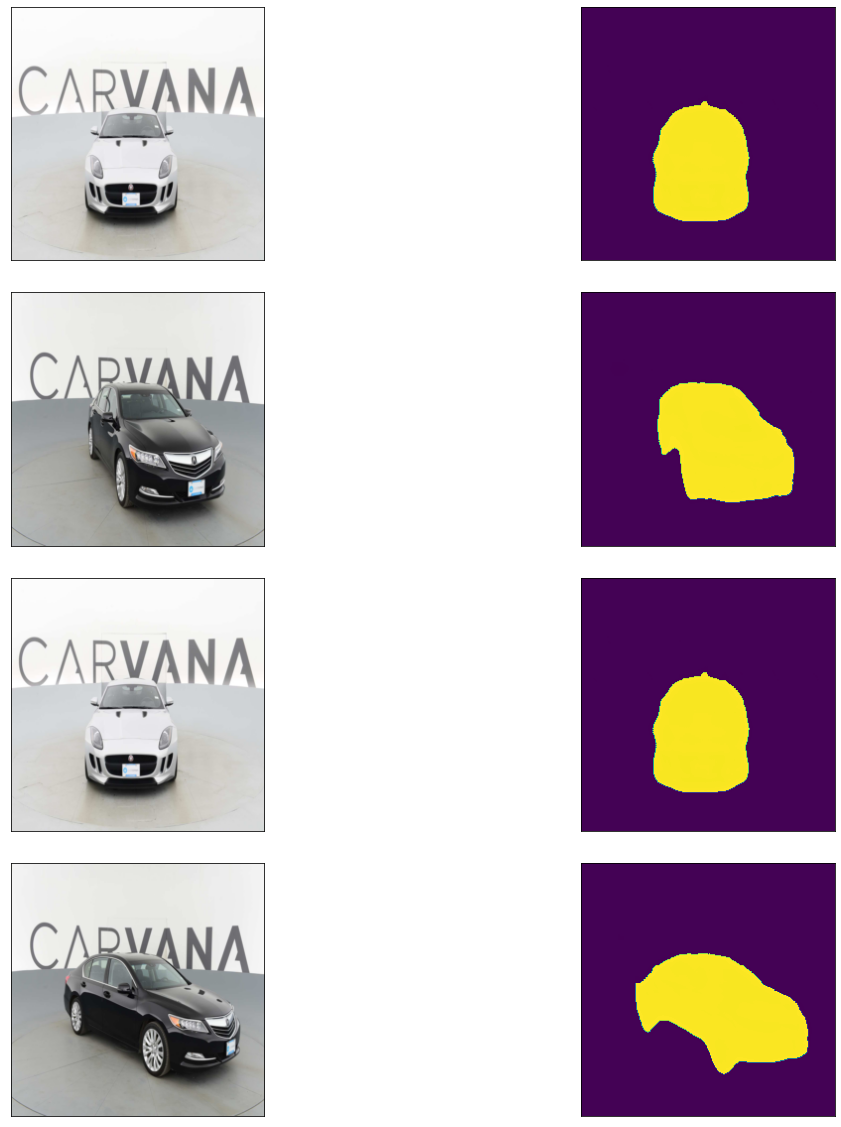

In [69]:
img_list = []
for i in range(4):
    img, label = train_dataset[np.random.randint(0, 100)]
    pred = model(img.unsqueeze(0).cuda()).detach().squeeze(0).cpu()
    pred= np.round(pred)
    img_list.append((img, pred))

im_show(img_list)